 <!-- # Convolutional Neural Networks for Text Classification -->
# M3.1 Convolutional Neural Network
 [![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/cltl/ml4nlp_tutorial_notebooks/blob/main/my_notebooks/m3_1_convolutional_neural_network.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cltl/ml4nlp_tutorial_notebooks/blob/main/my_notebooks/m3_1_convolutional_neural_network.ipynb)  


 In this tutorial, we explore how Convolutional Neural Networks (CNNs), originally developed for computer vision, can be applied to text classification tasks.


### Learning Objectives
By working through this notebook, you will learn:
 - Tokenization: first use-case of tokenizing our data, transforming the input text into numbers
 - Use case of training a CNN model for sentiment classification
 - Ablation of the CNN parameters: kernel size and number of features
 - Toy Dataset experiments: how does CNN detect different N-grams?

## 1. Introduction: Why CNNs for Text?

CNNs were originally designed for images where detecting patterns (like edges or shapes) matters more than their exact position. This property is called **translation invariance**. In short a cat is a cat, if it is on the left of an image or not. In general this approximation does not hold for text, the meaning of a string "this was an awesome movie" can be completely changed if it is follwed by the text "I would be lying if I said ...". But again we follow the Machine Learning mantra and use this approximation, as it turns out to be a very useful one for many text applications. 
<p align="center" >
    <img src="https://gracewlindsay.com/wp-content/uploads/2018/05/fncom-08-00135-g001.jpg" alt="cnn_humans_fig" style="max-width:40%; background-color: white;">
</p>

For text classification tasks like sentiment analysis, similar intuition applies. When determining if a review is positive or negative, certain phrases serve as strong indicators regardless of where they appear in the text:
- "absolutely amazing"
- "bored to death"
- "waste of time"

We care that these phrases occur, not their exact position. CNNs can learn to detect such n-gram patterns and use them for classification.

## 2. Building Blocks
A typical CNN architecture for text classification consists of:
1. **Embedding layer**: converts words to dense vectors
2. **Convolutional layer**: detects n-gram patterns with sliding windows
3. **Pooling layer**: aggregates pattern detections across positions
4. **Dense layer**: performs final classification

**Source**: Please see this blogpost for more information (also the source of many of the figures): https://lena-voita.github.io/nlp_course/models/convolutional.html

<p align="center" >
    <img src="https://lena-voita.github.io/resources/lectures/models/cnn/typical_cnn_with_cat-min.png" alt="cnn_main_fig" style="max-width:40%; background-color: white;">
</p>

### 2.1 Convolution for Text
Unlike images (2D), text is 1-dimensional. A convolutional filter slides over word embeddings with a fixed window size (kernel size).
- **Kernel size**: number of consecutive words the filter examines (e.g., 3 for trigrams)
- **Number of filters**: how many different patterns to learn
- Each filter acts as a pattern detector, computing similarity between its weights and the input window

### 2.2 Pooling
After convolution extracts features at each position, pooling aggregates them:
- **Max pooling**: takes the maximum activation for each filter across all positions
- **Global max pooling**: applies max pooling over the entire sequence
This gives us a fixed-size representation regardless of input length, answering "did this pattern occur anywhere?"

### *Load Standard Packages*
- We will load some other specific ones later in the document when we need them
- For our machine learning packages we will again use `pytorch` or `torch`. For this notebook we will use the subpackage `nn`, so keep in mind that we import this from torch so you know where it came from.   
    - FYI: The main machine learning package these days are indeed `pytorch` and `keras`, a package we will see for the next tutorial notebook about RNNs, but let's focus on torch for now.

In [1]:
# ignore warning messages for cleaner output of the website
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


 ## 3 Data Preparation: Building the Tokenizer

Untill now we have seen three different ways to process text data:
1. In a Bag-Of-Words (BOW) setup, where we just count the words to obtain a `DictVectorizer` (one-hot representation)
2. Using pre-trained Word Embeddings (e.g. Word2Vec)

We will now walk you through a more common approach, which does preserve the order of the words in a sentence (unlike the BOW setup).
This approach contains the following steps:
1. We preprocess the text to remove irrelevant parts of the data (for ease of computation, but newer models don't really do this anymore)
2. We construct a `Tokenizer` for our corpus. While tokenization can mean many thing, in Machine Learning a tokenizer is basically a dictionary which maps each input word to a number (e.g. "apple" -> 42). However, a corpus often contains many words only once or sometimes twice, a phenomena known as [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law) tells us that for many corpuses if we order all the words based on their frequency, the frequency of the n-th word (which we say has _rank_ n) is 1/n. As illustrated by the equation and plot below, we obtain a lot very uncommon words. Learning all these words will result in a lot of noise for our predictions (if we only have 1 case of a word, it's not a very reliable predictor), and it takes us way more computation to learn the relationship for all of them. Therefore a common practice for smaller models and datasets is to only keep the top N most frequent words, and replace the others with a special token `<UNK>`. 

$${\displaystyle \ {\mathsf {word\ frequency}}\ \propto \ {\frac {1}{\ {\mathsf {word\ rank}}\ }}~.}$$
<p align="center" >
    <img src="https://www.researchgate.net/publication/282200883/figure/fig3/AS:647173804945438@1531309667829/A-Zipf-distribution-of-word-frequencies.png" alt="zipfslaw_fig" style="max-width:20%; background-color: white;">
</p>


In [2]:
# Load IMDB dataset
print("Loading IMDB dataset...")
imdb_train_full = load_dataset('imdb', split='train')
imdb_test = load_dataset('imdb', split='test')

# shuffle data
imdb_train_full.shuffle()
imdb_test.shuffle()

# Extract texts and labels
X_train_full, y_train_full = imdb_train_full['text'], imdb_train_full['label']
X_test, y_test = imdb_test['text'], imdb_test['label']


X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)

Loading IMDB dataset...


In [3]:
print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Train samples: 22500
Validation samples: 2500
Test samples: 25000


#### Preprocess the data and tokenize
- Preprocess data
- Create a Tokenizer

In [4]:
import string
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)
STOPWORDS_SET = set(stopwords.words('english'))

In [5]:

def preprocess_data(text, remove_stopwords=False):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation (simple version)
    text = ''.join([ch for ch in text if ch not in string.punctuation])

    #  We don't do this right now but common options are:
    if remove_stopwords:
        words = text.split()
        words = [w for w in words if w not in STOPWORDS_SET]
        text = ' '.join(words)

    return text

# Build vocabulary from training data
def build_vocab(texts, max_vocab_size=10000):
    """Build vocabulary from texts."""
    word_counts = Counter()
    for text in texts:
        text = preprocess_data(text)
        words = text.split()
        word_counts.update(words)
    
    # Print original number of unique words
    print(f"Original vocabulary size (unique words): {len(word_counts)} - so we only keep {100 * max_vocab_size / len(word_counts):.2f}%")
    
    # Keep most common words
    most_common = word_counts.most_common(max_vocab_size - 2)  # -2 for PAD and UNK
    
    # Create word to index mapping
    word2idx = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in most_common:
        word2idx[word] = len(word2idx)
    
    return word2idx

# Build vocabulary
vocab = build_vocab(X_train, max_vocab_size=10000)
index2word = {idx: word for word, idx in vocab.items()}
print(f"Vocabulary size: {len(vocab)}")


Original vocabulary size (unique words): 114321 - so we only keep 8.75%
Vocabulary size: 10000


In [6]:
def texts_to_sequences(texts, word2idx, max_length=256):
    """Convert texts to sequences of indices."""
    sequences = []
    for text in texts:
        # words = text.lower().split()
        words = preprocess_data(text).split()
        seq = [word2idx.get(word, word2idx['<UNK>']) for word in words]
        # Truncate or pad
        if len(seq) > max_length:
            seq = seq[:max_length]
        else:
            seq = seq + [word2idx['<PAD>']] * (max_length - len(seq))
        sequences.append(seq)
    return np.array(sequences)

# Convert to sequences
MAX_LENGTH = 256
X_train_seq = texts_to_sequences(X_train, vocab, MAX_LENGTH)
X_test_seq = texts_to_sequences(X_test, vocab, MAX_LENGTH)
X_val_seq = texts_to_sequences(X_val, vocab, MAX_LENGTH)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}")


Training sequences shape: (22500, 256)
Test sequences shape: (25000, 256)


In [7]:
sample_idx = 0
max_words = 10

x_train_samlple = X_train[sample_idx]
X_train_seq_sample = X_train_seq[sample_idx]
x_train_recast = [index2word[idx] for idx in X_train_seq_sample]

print("="*40)
print("Example sequence (first training example):")
print("- Input string (original):")
print(x_train_samlple[:min(100, len(x_train_samlple))] + "...")  # Show first 100 chars
print(" - First 10 words:                       ", repr(", ".join(x_train_samlple.split()[:max_words])))
print(" - Sequence indices (first 10):          ", ", ".join(str(idx) for idx in X_train_seq_sample[:max_words]))
print(" - Recasted words from indices (first 10):", ", ".join(x_train_recast[:max_words]))
print("="*40)

Example sequence (first training example):
- Input string (original):
I was p***ed when I couldn't see this one when it was screening at the Philly Film Fest last year, s...
 - First 10 words:                        "I, was, p***ed, when, I, couldn't, see, this, one, when"
 - Sequence indices (first 10):           10, 14, 1, 51, 10, 404, 66, 11, 29, 51
 - Recasted words from indices (first 10): i, was, <UNK>, when, i, couldnt, see, this, one, when


**Observation:** In the above example we see an example of an input sentence, which is tokenized to numbers, and then using the tokenizer back into words. We see that in this process some information has been lost (purposefully). Namely we don't know if a word was uppercase or lowercase before, and some words such as "CURIOUS-YELLOW" are replaced by our unknown token symbol `<UNK>`. 

In [8]:
# Create PyTorch datasets class
class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.LongTensor(sequences)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = TextDataset(X_train_seq, y_train)
test_dataset = TextDataset(X_test_seq, y_test)
val_dataset =  TextDataset(X_val_seq, y_val)


**Note:** For the next experiments we only use the three dataset variables. Pytorch makes it very easy for us to train a model for a dataset, but it does ask of us that we present our dataset first in a dataset class, which is why we create the small dataset class above.

 ## 4. CNN Model for Sentiment Classification


---
 ### 4.1 Model Architecture
 - The important components for the CNN layer are `nn.Conv1d()` from pytorch, which takes care of most of the complicated parts for us. Check out the documentation here to understand what parameters we can give it.

In [9]:
class TextCNN(nn.Module):
    """CNN for text classification."""
    
    def __init__(self, vocab_size, embedding_dim, num_filters, kernel_size, num_classes):
        super(TextCNN, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Convolutional layer
        # Input: (batch, embedding_dim, sequence_length)
        # Output: (batch, num_filters, sequence_length - kernel_size + 1)
        self.conv = nn.Conv1d(
            in_channels=embedding_dim,
            out_channels=num_filters,
            kernel_size=kernel_size
        )
        
        # Activation function and Classifica
        self.relu = nn.ReLU()
        self.fc = nn.Linear(num_filters, num_classes) # Classification layer
        
        # we set the pooling function here as a variable. Note the lack of brackets "()" at the end, which means we are not calling the function yet
        # we could later also add another pooling function and switch between them
        self.pool = self.max_pool1d
    
    def max_pool1d(self, x):
        return torch.max(x, dim=2)[0]
    
    def forward(self, x):
        # convert each token_id to an embedding (vector)
        embedded = self.embedding(x)           # (batch, seq_len, embed_dim)
        embedded = embedded.transpose(1, 2)    # (batch, embed_dim, seq_len)
        
        #  Apply convolutional layer and pooling
        conv_out = self.conv(embedded)         # (batch, num_filters, conv_seq_len)
        activated = self.relu(conv_out)        # (batch, num_filters, conv_seq_len)
        pooled = self.pool(activated)

        # Output predicted class (0 or 1), input is the number of filters)
        output = self.fc(pooled)               # (batch, num_classes)
        return output
    

# Create model
model = TextCNN(
    vocab_size=len(vocab),
    embedding_dim=100,
    num_filters=100,
    kernel_size=3,
    num_classes=2
).to(device)

print(model)


TextCNN(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (conv): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (fc): Linear(in_features=100, out_features=2, bias=True)
)


---
### 4.2 Training and Evaluation

 Some training specifications:
 - As discussed in tutorial notebook  M2.3 Neural Networks, when we train a neural network, we need to specify a loss function, and an optimizer. 
    -  We use the `Adam` optimizer, which is currently one of the most widely used optimizer (and invented by a guy from the UvA, called Max Welling and some other dude named Kingma). The `Adam` is a tad more fancy optimizer than the classical `Stochastic Gradient Descent` (SGD). The main benefit of `Adam` is that it is more stable (i.e. we optimize it in the best possible way to get the best model).
    - For classification tasks a typical loss function is the `CrossEntropyLoss()`, see the previous tutorial notebooks for more info.

In [52]:
def train_model(model, train_dataset, val_dataset, test_dataset, epochs=5, batch_size=64, lr=0.001, verbose=True):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0.0
    best_epoch = 0
    best_model_path = "best_model.pt"

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", disable=not verbose):
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_acc = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_acc = val_correct / val_total

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(), best_model_path)

        if verbose:
            print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    # Load best model
    if verbose:
        print(f"Loading best model from epoch {best_epoch+1} with Val Acc={best_val_acc:.4f}")
    model.load_state_dict(torch.load(best_model_path))

    # Test set evaluation
    test_correct = 0
    test_total = 0
    model.eval()
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_acc = test_correct / test_total

    return history, test_acc

# Create model
model = TextCNN(
    vocab_size=len(vocab),
    embedding_dim=100,
    num_filters=100,
    kernel_size=2,
    num_classes=2
).to(device)

# Train the model
history, test_acc = train_model(model, train_dataset, val_dataset, test_dataset, epochs=5, batch_size=64, verbose=True)
print(f"Test Accuracy (best model): {test_acc:.4f}")


Epoch 1/5: 100%|██████████| 352/352 [00:01<00:00, 321.17it/s]


Epoch 1: Train Loss=0.5244, Train Acc=0.7348, Val Acc=0.7892


Epoch 2/5: 100%|██████████| 352/352 [00:00<00:00, 458.21it/s]


Epoch 2: Train Loss=0.3502, Train Acc=0.8522, Val Acc=0.8460


Epoch 3/5: 100%|██████████| 352/352 [00:00<00:00, 474.34it/s]


Epoch 3: Train Loss=0.2653, Train Acc=0.8953, Val Acc=0.8556


Epoch 4/5: 100%|██████████| 352/352 [00:00<00:00, 478.11it/s]


Epoch 4: Train Loss=0.1962, Train Acc=0.9304, Val Acc=0.8420


Epoch 5/5: 100%|██████████| 352/352 [00:00<00:00, 457.64it/s]


Epoch 5: Train Loss=0.1416, Train Acc=0.9546, Val Acc=0.8652
Loading best model from epoch 5 with Val Acc=0.8652
Test Accuracy (best model): 0.8574


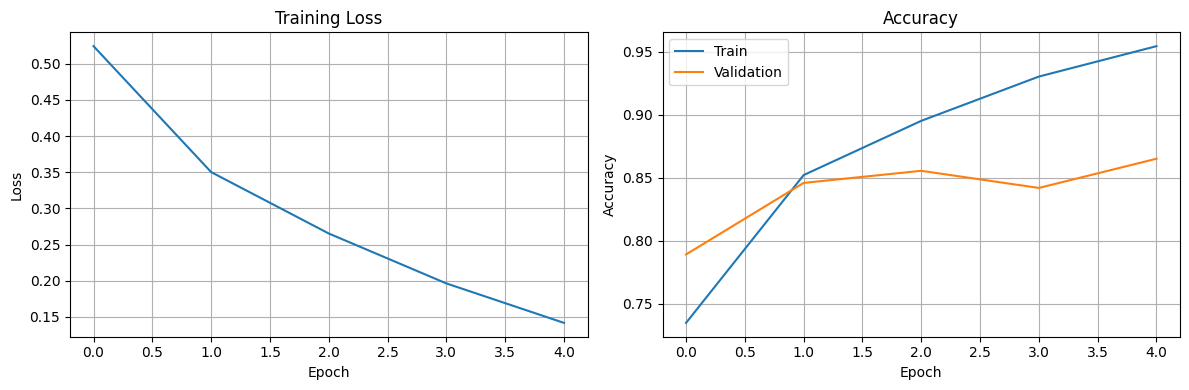

In [53]:
# Visualize training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**Observations**:
When inspecting the accuracy per epoch we notice a few important things. The first one is that the accuracy for both the train and the test split is pretty good, so since it is increasing and higher than 50\% (which would be random guessing), we notice that the model has learned something.  Moreover, the accuracy for both datasets seems to be increasing still after 5 epochs, so normally this tells us we should train the model longer so that we have the optimal performance, however, for now we leave it at this and explore some more parameters of the model.

--- 

## 5. Parameter Exploration
We now systematically vary key hyperparameters to understand their effect on performance.

 ### 5.1 Effect of Kernel Size

 <p align="center" >
    <img src="https://lena-voita.github.io/resources/lectures/models/cnn/kernel_size-min.png" alt="cnn_kernelsize_fig" style="max-width:80%; background-color: white;">
</p>

In [54]:
def evaluate_model(model, test_dataset, batch_size=64):
    """Evaluate model and return accuracy."""
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

# Test different kernel sizes
kernel_sizes = [1, 2, 3, 4, 5]
kernel_results = []

# print("Testing different kernel sizes...")
for k_size in tqdm(kernel_sizes):    
    model = TextCNN(
        vocab_size=len(vocab),
        embedding_dim=100,
        num_filters=100,
        kernel_size=k_size,
        num_classes=2
    ).to(device)
    
    history, final_acc = train_model(model, train_dataset, val_dataset, test_dataset, epochs=5, batch_size=64, verbose=False)
    kernel_results.append(final_acc)


100%|██████████| 5/5 [00:20<00:00,  4.14s/it]


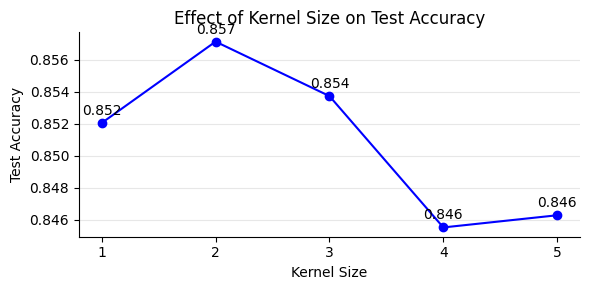

In [55]:
def plot_tuning_results(x_values, y_values, x_axis_label, title='Hyperparameter Tuning', marker='o', color='b', y_plot_delta=0.0005, return_fig=False):
    plt.figure(figsize=(6, 3))
    plt.plot(x_values, y_values, marker=marker, linestyle='-', color=color)
    plt.xlabel(x_axis_label)
    plt.ylabel('Test Accuracy')
    plt.title(title)
    plt.xticks(x_values)
    plt.grid(True, axis='y', alpha=0.3)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for i, acc in enumerate(y_values):
        plt.text(x_values[i], acc + y_plot_delta, f'{acc:.3f}', ha='center')

    if return_fig:
        return plt.gcf()
    else:
        plt.tight_layout()
        plt.show()

plot_tuning_results(kernel_sizes, kernel_results, x_axis_label='Kernel Size', title='Effect of Kernel Size on Test Accuracy')

**Observation:** We see that the accuracy for kernel size 2 achieves the best test accuracy. One likely reason is that increasing the kernel size increases the complexity of the task as well (there are many more tri-grams, than bi-grams to learn). 

### 5.2 Effect of Number of Filters
- The number of filters determines the numbmer of features we obtain at the end. In simple terms it increases the computational power of our model. 

However, like before with more computational power we obtain the classical trade-off: 
- The computational complexity increase: we need better hardware and longer training time to train our models
- We have higher risk of overfitting: the model might memorize the training data, causing very high accuracy on the training split, but obtaining bad accurcy on the test and validation splits.
  <p align="center" >
    <img src="https://lena-voita.github.io/resources/lectures/models/cnn/several_filters-min.png" alt="cnn_stride_fig" style="max-width:20%; background-color: white;">
</p>

In [56]:
# Test different numbers of filters and store parameter counts
num_filters_list = [5, 25, 50, 100, 200]
filter_results = []
param_counts = []

print("Testing different numbers of filters...")
for num_f in tqdm(num_filters_list):
    model = TextCNN(
        vocab_size=len(vocab),
        embedding_dim=100,
        num_filters=num_f,
        kernel_size=3,
        num_classes=2
    ).to(device)
    
    # Store total number of parameters
    param_counts.append(sum(p.numel() for p in model.parameters()))
    
    history, final_acc = train_model(model, train_dataset, val_dataset, test_dataset, epochs=3, batch_size=64, verbose=False)
    filter_results.append(final_acc)

print("Parameter counts for each num_filters:", param_counts)



Testing different numbers of filters...


100%|██████████| 5/5 [00:13<00:00,  2.61s/it]

Parameter counts for each num_filters: [1001517, 1007577, 1015152, 1030302, 1060602]


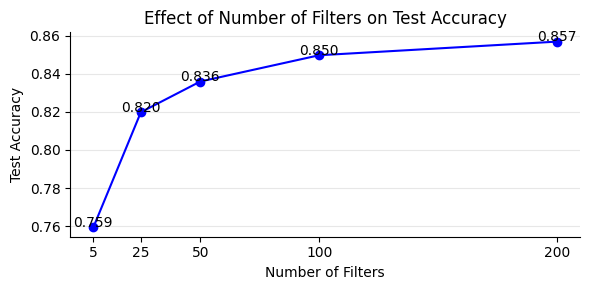

In [57]:
plot_tuning_results(num_filters_list, filter_results, x_axis_label='Number of Filters', title='Effect of Number of Filters on Test Accuracy', y_plot_delta=0.0002)

# plot number of parameters
# plot_tuning_results(num_filters_list, param_counts, x_axis_label='Number of Parameters', title='Effect of Number of Parameters on Test Accuracy', y_plot_delta=0.0002)

**Observation**: 
- We see that the number of filters helps us a lot and increases the accuracy reliably up to 200 filters. However, the improvement in accuracy does result in diminishing returns, as doubling the number of filters from 100 to 200 only increases the test accuracy by 7%.
<!-- but after after 100 filters this patter stops. As usual the model has likely learned to _overfit_ on the training data. -->

### 5.3 [TODO] Stride
 - Improves efficiency (run with timing)
 - But also if we use a stride higher than 1, we miss some tri-gram information. 

 <p align="center" >
    <img src="https://lena-voita.github.io/resources/lectures/models/cnn/stride-min.png" alt="cnn_stride_fig" style="max-width:80%; background-color: white;">
</p>

 ### 5.4 Multiple Kernel Sizes (Parallel Convolutions)
- We can also use a combination of different kernelsizes to obtain further improve our model.
<!-- - Following Kim (2014), we can use multiple convolutions with different kernel sizes in parallel and concatenate their outputs. -->

In [58]:
class MultiKernelCNN(nn.Module):
    """CNN with multiple kernel sizes in parallel."""
    
    def __init__(self, vocab_size, embedding_dim, num_filters, kernel_sizes, num_classes):
        super(MultiKernelCNN, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Multiple convolutional layers with different kernel sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, k)
            for k in kernel_sizes
        ])
        
        self.relu = nn.ReLU()
        
        # Output size is num_filters * number of kernels
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)
        
    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)
        embedded = embedded.transpose(1, 2)
        
        # Apply each convolution and pool
        conv_outputs = []
        for conv in self.convs:
            conv_out = self.relu(conv(embedded))
            pooled = torch.max(conv_out, dim=2)[0]
            conv_outputs.append(pooled)
        
        # Concatenate all pooled outputs
        concatenated = torch.cat(conv_outputs, dim=1)
        
        # Classification
        output = self.fc(concatenated)
        
        return output

# Train multi-kernel model
print("Training multi-kernel CNN...")
multi_model = MultiKernelCNN(
    vocab_size=len(vocab),
    embedding_dim=100,
    num_filters=100,
    kernel_sizes=[2, 3, 4],
    num_classes=2
).to(device)

multi_history, final_acc = train_model(multi_model, train_dataset, val_dataset, test_dataset, epochs=5, batch_size=64, verbose=False)
print(f"Multi-kernel final accuracy: {final_acc:.4f}")


Training multi-kernel CNN...
Multi-kernel final accuracy: 0.8611


**Observation**: We see that increasing the number of filters can help us more with classification. But do note that for each kernel, we get num_filters of filters, so effectively we just have set the number of filters to 300.


---
## 6. Toy Dataset: Understanding Limitations
We create a synthetic dataset to demonstrate that a CNN with kernel size k cannot capture patterns longer than k tokens.

####  6.1✨ N-Gram Statistics ✨
- To understand how CNNs are related to kernel size, we inspect sample patterns below.
- CNN filters with kernel size N can examine at most N consecutive tokens at a time.

In [59]:
# Our Patterns
positive_pattern = "A B A C A"
negative_pattern = "A C A B A"

In [60]:
import pandas as pd
from IPython.display import HTML

def compute_ngram_stats(positive_pattern, negative_pattern, n):
    """
    Compute n-gram statistics for two patterns.
    
    Args:
        positive_pattern: String of space-separated tokens (e.g., "A B A C A")
        negative_pattern: String of space-separated tokens (e.g., "A C A B A")
        n: n-gram size (e.g., 1 for unigrams, 2 for bigrams)
    
    Returns:
        DataFrame with Positive and Negative count columns
    """
    def extract_ngrams(pattern_str, n):
        tokens = pattern_str.split()
        return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    
    # Extract n-grams
    grams_pos = extract_ngrams(positive_pattern, n)
    grams_neg = extract_ngrams(negative_pattern, n)
    
    # Count occurrences
    counts_pos = pd.Series(grams_pos).value_counts().sort_index()
    counts_neg = pd.Series(grams_neg).value_counts().sort_index()
    
    # Combine into single DataFrame
    df = pd.DataFrame({
        'Positive': counts_pos,
        'Negative': counts_neg
    }).fillna(0).astype(int)
    
    return df

# Display unigram statistics
unigram_df = compute_ngram_stats(positive_pattern, negative_pattern, n=1)
print("1-gram (unigram) statistics:")
display(unigram_df)


1-gram (unigram) statistics:


,Positive,Negative
"(A,)",3,3
"(B,)",1,1
"(C,)",1,1


#### Calculate: N-gram statistics for N=1,2,3,4

In [61]:
# Display all n-grams (1 through 4) side by side
def display_ngrams_horizontal(positive_pattern, negative_pattern, n_range):
    """
    Display multiple n-gram statistics side by side.
    
    Args:
        positive_pattern: List of tokens for positive pattern
        negative_pattern: List of tokens for negative pattern
        n_range: Iterable of n values (e.g., range(1, 5) for 1-4 grams)
    """
    # Compute all n-gram dataframes
    dfs = []
    titles = []
    for n in n_range:
        df = compute_ngram_stats(positive_pattern, negative_pattern, n)
        dfs.append(df)
        titles.append(f'{n}-gram')
    
    # Fancy trick; Build HTML for side-by-side display (we could also skip them and do diplay(df) one by one, but this takes up more vertical space)
    html = '<div style="display:flex">'
    for df, title in zip(dfs, titles):
        html += '<div style="margin-right: 32px">'
        html += f'<h4 style="text-align: center;">{title}</h4>'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    
    display(HTML(html))

# Display 1-grams through 4-grams side by side
display_ngrams_horizontal(positive_pattern, negative_pattern, range(1, 5))

,Positive,Negative
"(A,)",3,3
"(B,)",1,1
"(C,)",1,1
,Positive,Negative
"(A, B)",1,1
"(A, C)",1,1
"(B, A)",1,1
"(C, A)",1,1
,Positive,Negative
"(A, B, A)",1,1


**Observations**:
- We see that for our sample patterns, the unigram and bigram statistics are exactly the same. From the tri-gram statistics the patterns are distinguishable. The subpattern "B A C" is in the positive pattern, and the subpattern "C A B" is only in the negative pattern. Do keep in mind that for our dataset we insert this pattern into a random string of letters, so it could always be the case that one of these patterns appears by chance in a sample. This is very similar to real machine learning situations, where many patterns give us probabilities of a class, but can may also appear in the counter correlated class too. 

### Generate Toy Dataset

In [62]:
from termcolor import colored

def pretty_print(full_string, sub_string, color='red'):
    """
    Print full_string with sub_string highlighted in the specified color.
    Supports basic colors: red, blue, green, yellow, magenta, cyan, white, grey.
    """
    full_tokens = full_string.split()
    sub_tokens = sub_string.split()
    n = len(sub_tokens)
    for i in range(len(full_tokens) - n + 1):
        if full_tokens[i:i+n] == sub_tokens:
            before = ' '.join(full_tokens[:i])
            highlight = colored(' '.join(full_tokens[i:i+n]), color)
            after = ' '.join(full_tokens[i+n:])
            print(f"{before} {highlight} {after}".strip())
            return
    print(full_string)

In [63]:
def generate_ngram_data_letters(pos_pattern, neg_pattern, n_samples=1000, vocab_size=26, seq_length=20):
    """
    Generate synthetic text data as strings of letters.
    Labels alternate deterministically: 1, 0, 1, 0, ...
    """
    X = []
    y = []
    import string
    vocab = list(string.ascii_uppercase[:vocab_size])
    for i in range(n_samples):
        seq = np.random.choice(vocab, size=seq_length, replace=True)
        label = 1 if i % 2 == 0 else 0
        if label == 1:
            pos = np.random.randint(0, seq_length - len(pos_pattern.split()) + 1)
            seq[pos:pos + len(pos_pattern.split())] = pos_pattern.split()
        else:
            pos = np.random.randint(0, seq_length - len(neg_pattern.split()) + 1)
            seq[pos:pos + len(neg_pattern.split())] = neg_pattern.split()
        X.append(' '.join(seq))
        y.append(label)
    return X, np.array(y)


# Generate synthetic text data with letter patterns as strings
X_train_toy_letters, y_train_toy = generate_ngram_data_letters(n_samples=2000, pos_pattern=positive_pattern, neg_pattern=negative_pattern)
X_test_toy_letters, y_test_toy = generate_ngram_data_letters(n_samples=500, pos_pattern=positive_pattern, neg_pattern=negative_pattern)

print(f"Example sequence (with positive pattern highlighted) - Label {y_train_toy[0]} (1 is positive):")
pretty_print(X_train_toy_letters[0], positive_pattern, color='green')

# now print second example which is negative
print(f"\nExample sequence (with negative pattern highlighted) - Label {y_train_toy[1]} (0 is negative):")
pretty_print(X_train_toy_letters[1], negative_pattern, color='red')

Example sequence (with positive pattern highlighted) - Label 1 (1 is positive):
W K T A B A C A Y V E U R P H D D X D Q

Example sequence (with negative pattern highlighted) - Label 0 (0 is negative):
J A A C A B A P D X R U K H A V B U Q T


**Observation:** Make sure you understand what the data looks like at this point. In the above example we have colored the subpattern in a different way to help you find it. 

#### Convert Data: strings to list of numbers
- Similar to the tokenizer from before, we convert the input text to numbers. In this case the "tokenizer" just gives us which letter of the alphabet a letter is. 

In [64]:
def convert_data_to_numb(X, vocab=None):
    """
    Convert list of letter strings to list of indices.
    """
    import string
    if vocab is None:
        vocab = {char: idx for idx, char in enumerate(string.ascii_uppercase)}
    X_numb = []
    for seq in X:
        tokens = seq.split()
        indices = [vocab.get(token, 0) for token in tokens]
        X_numb.append(indices)
    return np.array(X_numb)


# # Convert the data to indices
toy_vocab = {char: idx for idx, char in enumerate('ABCDEFGHIJKLMNOPQRSTUVWXYZ')}
X_train_toy = convert_data_to_numb(X_train_toy_letters, vocab=toy_vocab)
X_test_toy = convert_data_to_numb(X_test_toy_letters, vocab=toy_vocab)

print(f"Original sequence: {X_train_toy_letters[0]}")
print(f"Converted to indices: {X_train_toy[0]}")


# # Create datasets
toy_train_dataset = TextDataset(X_train_toy, y_train_toy)
toy_test_dataset = TextDataset(X_test_toy, y_test_toy)

Original sequence: W K T A B A C A Y V E U R P H D D X D Q
Converted to indices: [22 10 19  0  1  0  2  0 24 21  4 20 17 15  7  3  3 23  3 16]


 ### 6.2 Experiment with Kernel Sizes

 We test whether models with different kernel sizes can learn the trigram pattern.

In [65]:
# Test kernel sizes on toy data
toy_kernel_sizes = [1, 2, 3, 4, 5]
toy_results = []

print("Testing kernel sizes on letter pattern data...")
for k_size in tqdm(toy_kernel_sizes):
    # print(f"\nKernel size: {k_size}")
    
    toy_model = TextCNN(
        vocab_size=26,  # A-Z alphabet
        embedding_dim=16,
        num_filters=32,
        kernel_size=k_size,
        num_classes=2
    ).to(device)
    
    # Train for more epochs on toy data (it's smaller)
    # Use test as validation for now. Since we don't really check val acc here.
    toy_history, final_acc = train_model(toy_model, toy_train_dataset, toy_test_dataset, toy_test_dataset, 
                               epochs=10, batch_size=32, lr=0.01, verbose=False)
    toy_results.append(final_acc)


Testing kernel sizes on letter pattern data...


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


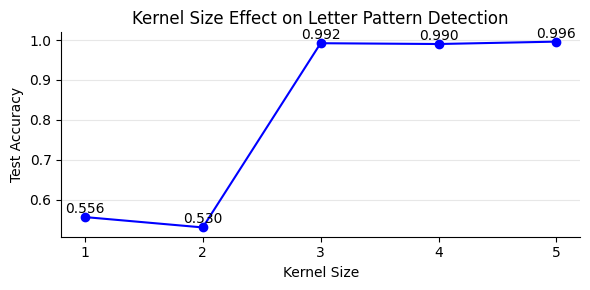

In [66]:
plot_tuning_results(
    toy_kernel_sizes,
    toy_results,
    x_axis_label='Kernel Size',
    title='Kernel Size Effect on Letter Pattern Detection',
    y_plot_delta=0.01
)


 **Observation**: The model with smaller kernel sizes cannot learn the 5-gram pattern (`A B A C A` vs `A C A B A`), achieving near-random accuracy. Only models with kernel size ≥ 5 can successfully learn to distinguish these patterns, demonstrating that CNNs require sufficient kernel size to capture the complete n-gram patterns. This mirrors real NLP scenarios where certain phrases or word sequences are only meaningful when captured in full.

 <!-- ## 7. Summary
 ### Key Takeaways
 1. **CNNs detect position-invariant patterns**: Through convolution and global pooling, CNNs identify whether specific n-gram patterns occur anywhere in the text, making them suitable for tasks where pattern presence matters more than position.
 2. **Kernel size determines receptive field**: The kernel size must be at least as large as the patterns you want to detect. A kernel size of k can only capture up to k-grams.
 3. **Multiple kernel sizes improve robustness**: Using parallel convolutions with different kernel sizes (2, 3, 4) allows the model to capture various n-gram lengths simultaneously.
 4. **Efficiency and simplicity**: CNNs are computationally efficient compared to recurrent models, as all convolutions can be computed in parallel. -->



## 7. Self-Check Questions
- What does the kernel size in a CNN determine when applied to text?
- Why might global max pooling cause loss of positional information?
- How can using multiple kernel sizes in parallel benefit text classification?
- In what scenarios are CNNs preferable Neural Networks?
- What are some limitations of CNNs for modeling long-range dependencies in text?

<!-- 
 ### Limitations
 - **Fixed receptive field**: Even with stacked layers, CNNs have limited ability to model long-range dependencies
 - **No sequential modeling**: Unlike RNNs, CNNs don't explicitly model word order beyond the kernel window
 - **Position information loss**: Global pooling discards positional information, which may be important for some tasks

 ### When to Use CNNs for Text
 CNNs work well when:
 - Local n-gram patterns are strong indicators (sentiment analysis, topic classification)
 - Speed and efficiency are important
 - Input lengths are moderate -->